In [12]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn import mixture
from datetime import datetime

## Read data

In [2]:
raw_data = pd.read_excel('clustering.xlsx')
data = pd.DataFrame(raw_data, columns=['package_type','preferred_genre','intended_use','weekly_consumption_hour','age',
                                   'male_TF','attribution_technical','attribution_survey','op_sys','plan_type',
                                   'discount_price','account_creation_date','initial_credit_card_declined',
                                    'join_fee','current_sub_TF','payment_period','trial_completed'])
data

,package_type,preferred_genre,intended_use,weekly_consumption_hour,age,male_TF,attribution_technical,attribution_survey,op_sys,plan_type,discount_price,account_creation_date,initial_credit_card_declined,join_fee,current_sub_TF,payment_period,trial_completed
0,enhanced,regional,replace OTT,36.001186,25.0,True,organic,facebook,iOS,base_14,4.5141,2019-12-07 16:37:06,False,0.1101,False,0,True
1,base,drama,replace OTT,20.051667,30.0,False,search,tv,Android,base_14,4.5141,2020-01-27 16:09:32,False,0.0367,False,0,True
2,base,comedy,replace OTT,22.951579,28.0,False,discovery,youtube,iOS,base_14,4.5141,2019-10-05 12:57:07,False,0.0367,True,2,True
3,base,comedy,access to exclusive content,20.051667,61.0,False,bing,search,Android,base_14,4.5141,2020-02-19 18:30:15,False,0.3303,True,1,True
4,base,drama,access to exclusive content,34.551230,23.0,False,email,referral,iOS,base_14,4.5141,2020-03-05 14:52:22,False,0.0000,True,1,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
144078,base,drama,access to exclusive content,24.401536,43.0,False,email,pinterest,iOS,base_14,4.5141,2020-01-01 22:43:56,False,0.0000,True,1,True
144079,enhanced,comedy,supplement OTT,28.751405,38.0,False,facebook,facebook_organic,iOS,base_14,4.5141,2019-11-17 14:12:33,False,0.3303,True,1,True
144080,enhanced,comedy,replace OTT,27.301448,49.0,False,google_organic,referral,iOS,base_14,4.5141,2019-12-06 18:02:13,False,0.3303,True,1,True
144081,base,comedy,access to exclusive content,31.651317,45.0,False,facebook,facebook,iOS,base_14,4.5141,2019-12-21 19:40:44,True,0.0367,True,1,True


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144083 entries, 0 to 144082
Data columns (total 17 columns):
 #   Column                        Non-Null Count   Dtype         
---  ------                        --------------   -----         
 0   package_type                  144083 non-null  object        
 1   preferred_genre               144083 non-null  object        
 2   intended_use                  144083 non-null  object        
 3   weekly_consumption_hour       144083 non-null  float64       
 4   age                           144083 non-null  float64       
 5   male_TF                       144083 non-null  bool          
 6   attribution_technical         144083 non-null  object        
 7   attribution_survey            144083 non-null  object        
 8   op_sys                        144083 non-null  object        
 9   plan_type                     144083 non-null  object        
 10  discount_price                144083 non-null  float64       
 11  account_creat

In [4]:
df = data.copy()

## Reserve year and month only

In [5]:
df['account_creation_date'] = df['account_creation_date'].dt.date

In [6]:
df['account_creation_date'] = (pd.DatetimeIndex(df['account_creation_date']).year)*100 + (pd.DatetimeIndex(df['account_creation_date']).month)
df['account_creation_date']

0         201912
1         202001
2         201910
3         202002
4         202003
           ...  
144078    202001
144079    201911
144080    201912
144081    201912
144082    201911
Name: account_creation_date, Length: 144083, dtype: int64

## Dummy

In [7]:
# input string
def make_dummy_variable(df,variable):
    # Dummy
    variable_category = df[variable].astype('category')
    df_variable = pd.DataFrame(variable_category)
    
    # generate binary values using get_dummies
    dum_df = pd.get_dummies(df_variable, columns=[variable], prefix=[variable] )
    # merge with main df bridge_df on key values
    df = df.join(dum_df)
    # drop any one of the columns
    names = list(set(df[variable]))
    drop_name = variable + '_' + str(names[0])
    df = df.drop(columns=[drop_name])
    df = df.drop(columns=[variable])
    
    return df

In [8]:
df = make_dummy_variable(df,'package_type')
df = make_dummy_variable(df,'preferred_genre')
df = make_dummy_variable(df,'intended_use')
df = make_dummy_variable(df,'attribution_technical')
df = make_dummy_variable(df,'attribution_survey')
df = make_dummy_variable(df,'op_sys')
df = make_dummy_variable(df,'plan_type')
df = make_dummy_variable(df,'discount_price')
df = make_dummy_variable(df,'payment_period')
df = make_dummy_variable(df,'account_creation_date')

In [9]:
df

,weekly_consumption_hour,age,male_TF,initial_credit_card_declined,join_fee,current_sub_TF,trial_completed,package_type_economy,package_type_enhanced,preferred_genre_comedy,...,payment_period_3,account_creation_date_201906,account_creation_date_201907,account_creation_date_201908,account_creation_date_201909,account_creation_date_201910,account_creation_date_201911,account_creation_date_201912,account_creation_date_202002,account_creation_date_202003
0,36.001186,25.0,True,False,0.1101,False,True,0,1,0,...,0,0,0,0,0,0,0,1,0,0
1,20.051667,30.0,False,False,0.0367,False,True,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,22.951579,28.0,False,False,0.0367,True,True,0,0,1,...,0,0,0,0,0,1,0,0,0,0
3,20.051667,61.0,False,False,0.3303,True,True,0,0,1,...,0,0,0,0,0,0,0,0,1,0
4,34.551230,23.0,False,False,0.0000,True,True,0,0,0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
144078,24.401536,43.0,False,False,0.0000,True,True,0,0,0,...,0,0,0,0,0,0,0,0,0,0
144079,28.751405,38.0,False,False,0.3303,True,True,0,1,1,...,0,0,0,0,0,0,1,0,0,0
144080,27.301448,49.0,False,False,0.3303,True,True,0,1,1,...,0,0,0,0,0,0,0,1,0,0
144081,31.651317,45.0,False,True,0.0367,True,True,0,0,1,...,0,0,0,0,0,0,0,1,0,0


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144083 entries, 0 to 144082
Data columns (total 85 columns):
 #   Column                                         Non-Null Count   Dtype  
---  ------                                         --------------   -----  
 0   weekly_consumption_hour                        144083 non-null  float64
 1   age                                            144083 non-null  float64
 2   male_TF                                        144083 non-null  bool   
 3   initial_credit_card_declined                   144083 non-null  bool   
 4   join_fee                                       144083 non-null  float64
 5   current_sub_TF                                 144083 non-null  bool   
 6   trial_completed                                144083 non-null  bool   
 7   package_type_economy                           144083 non-null  uint8  
 8   package_type_enhanced                          144083 non-null  uint8  
 9   preferred_genre_comedy               

## Clustering - GMM

feature:
 ['weekly_consumption_hour', 'age', 'male_TF', 'initial_credit_card_declined', 'join_fee', 'current_sub_TF', 'trial_completed', 'package_type_economy', 'package_type_enhanced', 'preferred_genre_comedy', 'preferred_genre_drama', 'preferred_genre_international', 'preferred_genre_other', 'intended_use_access to exclusive content', 'intended_use_education', 'intended_use_expand international access', 'intended_use_expand regional access', 'intended_use_other', 'intended_use_supplement OTT', 'attribution_technical_affiliate', 'attribution_technical_appstore', 'attribution_technical_bing', 'attribution_technical_bing_organic', 'attribution_technical_brand sem intent bing', 'attribution_technical_brand sem intent google', 'attribution_technical_content_greatist', 'attribution_technical_criteo', 'attribution_technical_direct_mail', 'attribution_technical_discovery', 'attribution_technical_display', 'attribution_technical_email', 'attribution_technical_email_blast', 'attribution_techni

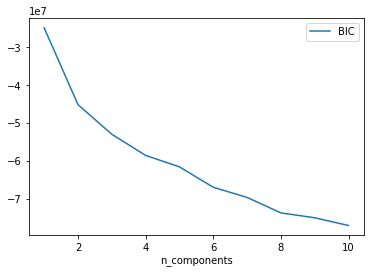

In [13]:
feature_x = [tag for tag in df.columns]
print('feature:\n', feature_x)
X = df[feature_x].values

# How many clusters?
n_components = np.arange(1, 11)
models = [mixture.GaussianMixture(n, covariance_type='full', random_state= 2020).fit(X) for n in n_components]
plt.plot(n_components, [m.bic(X) for m in models], label='BIC')
#plt.plot(n_components, [m.aic(X_train) for m in models], label='AIC')
plt.legend(loc='best')
plt.xlabel('n_components')
plt.show()

In [15]:
# GMM
GMM = mixture.GaussianMixture(n_components=4, covariance_type='full')
gmm = GMM.fit(X)
labels = gmm.predict(X)
raw_data['cluster'] = labels
raw_data.to_csv('clustered.csv')